<a href="https://colab.research.google.com/github/codiak/DTSA-5511/blob/main/DTSA_5511_Bank_Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Binary Classification with a Bank Churn Dataset
### Kaggle project as part of CU Boulder DTSA-5511

"Deep Learning" class participation in the Kaggle competition:
[Binary Classification with a Bank Churn Dataset](https://www.kaggle.com/competitions/playground-series-s4e1)

Based on the provided, synthetic data, the goal is to predict which customers will exit the bank.

Completed by Cody P (@codiak).

Github repo: https://github.com/codiak/DTSA-5511

In [ ]:
# Import necessary libraries
!pip install kaggle
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


## Introduction and Data Gathering

For this project, I found a Kaggle dataset with multiple features representing individuals who are customers at a bank. The problem the dataset was collected (and synthesized) for was to determine which customers are at risk of leaving the bank. In this case, the dataset does not represent real customers, but is instead synthesized based on a similar dataset of real customers. This is one of the most effective ways of maintaining privacy with sensitive data such as locations and credit scores.

To gather the data, I will use the Kaggle API to download the data to the notebook instance (improving ease of reproducibility).


### Problem and Goals

As the data was curated for targeting customer churn, that will be the focus of this project. This is a type of problem that could be applied to any business with repeat customers and some metadata about those customers. In addition to producing good results, the other goal will be to compare multiple machine learning models and compare their performance.

### Data Fetching

Using the Kaggle API to import the dataset.

In [ ]:
!mkdir -p ~/.kaggle
!cp /kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle competitions download -c playground-series-s4e1

100% 6.81M/6.81M [00:01<00:00, 8.47MB/s]
100% 6.81M/6.81M [00:01<00:00, 5.23MB/s]


In [ ]:
!unzip playground-series-s4e1.zip

Archive:  playground-series-s4e1.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [ ]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
sample_df = pd.read_csv('sample_submission.csv')

## Exploratory Data Analysis

In [92]:
train_df.sample(10)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
10865,10865,15658057,Toscani,658,Germany,Female,42.0,2,121765.37,2,1.0,1.0,166516.84,0
120664,120664,15796230,Yobanna,567,France,Male,38.0,1,0.00,2,1.0,0.0,176780.39,0
145243,145243,15791667,Yeh,580,France,Female,49.0,9,145541.35,1,1.0,0.0,181653.33,1
15552,15552,15761132,H?,597,France,Female,39.0,1,0.00,2,1.0,1.0,158887.09,0
50862,50862,15740406,Iadanza,574,Spain,Male,36.0,1,120193.42,2,1.0,1.0,91561.89,0
3469,3469,15590320,Cattaneo,556,France,Male,42.0,9,0.00,2,0.0,1.0,28667.56,0
136021,136021,15781665,T'ien,594,Spain,Male,30.0,5,0.00,2,0.0,1.0,98820.09,0
159642,159642,15750839,P'eng,681,France,Female,33.0,1,0.00,2,0.0,1.0,157557.22,0
82134,82134,15694192,Nwankwo,759,France,Male,38.0,3,0.00,2,0.0,1.0,173783.38,0
89120,89120,15664681,Rizzo,645,France,Female,26.0,7,137657.25,1,1.0,1.0,172557.71,0


In [ ]:
test_df.sample(5)

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
61209,226243,15674868,Hsia,586,Germany,Female,25.0,6,95675.62,1,1.0,0.0,163516.16
5321,170355,15717156,Palerma,691,France,Male,29.0,7,0.00,2,1.0,0.0,93717.47
19741,184775,15711588,Ts'ui,624,France,Female,40.0,3,0.00,2,1.0,1.0,125899.67
48557,213591,15783501,Ts'ai,573,France,Male,41.0,9,135289.47,1,1.0,0.0,69052.55
78377,243411,15798848,K?,731,Spain,Male,40.0,4,0.00,2,0.0,0.0,64448.36


The Kaggle competition expects a submission using the test dataset which does not include labels.

Let's take a look at the distribution of labels in train_df.

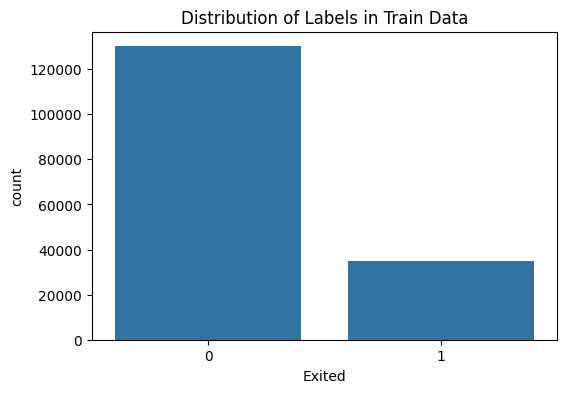

In [ ]:
# Graph label distribution
plt.figure(figsize=(6, 4))
sns.countplot(x='Exited', data=train_df)
plt.title('Distribution of Labels in Train Data')
plt.show()

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 165034 entries, 0 to 165033
Data columns (total 14 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   id               165034 non-null  int64  
 1   CustomerId       165034 non-null  int64  
 2   Surname          165034 non-null  object 
 3   CreditScore      165034 non-null  int64  
 4   Geography        165034 non-null  object 
 5   Gender           165034 non-null  object 
 6   Age              165034 non-null  float64
 7   Tenure           165034 non-null  int64  
 8   Balance          165034 non-null  float64
 9   NumOfProducts    165034 non-null  int64  
 10  HasCrCard        165034 non-null  float64
 11  IsActiveMember   165034 non-null  float64
 12  EstimatedSalary  165034 non-null  float64
 13  Exited           165034 non-null  int64  
dtypes: float64(5), int64(6), object(3)
memory usage: 17.6+ MB


165,034 samples is sufficiently large to apply most models we have discussed in DTSA-5511. The dataset is heavily weighted towards negative samples, which will be worth keeping in mind during training. Otherwise, each of the 11 features do not contain null values.

Looking deeper at the features, look at the distribution of values in various features and compare their saliency.

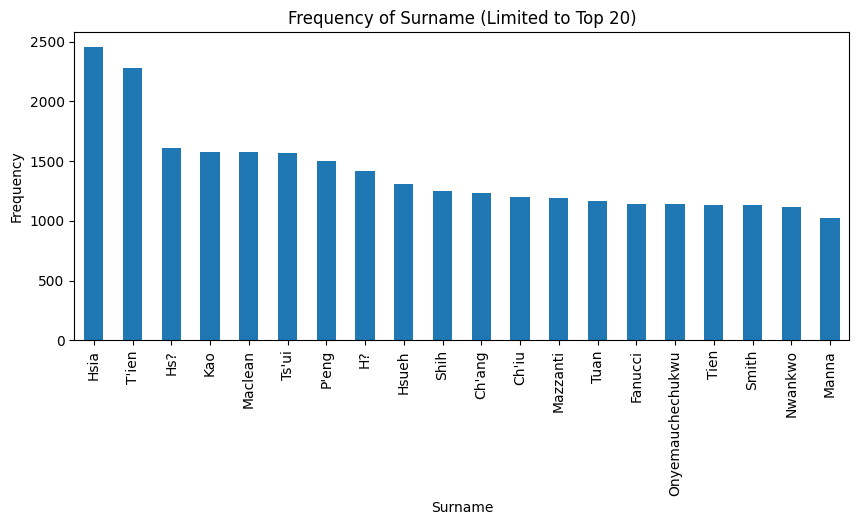

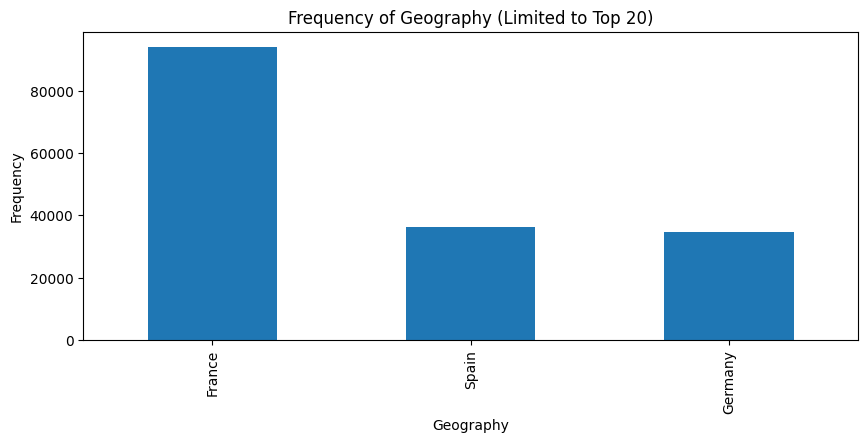

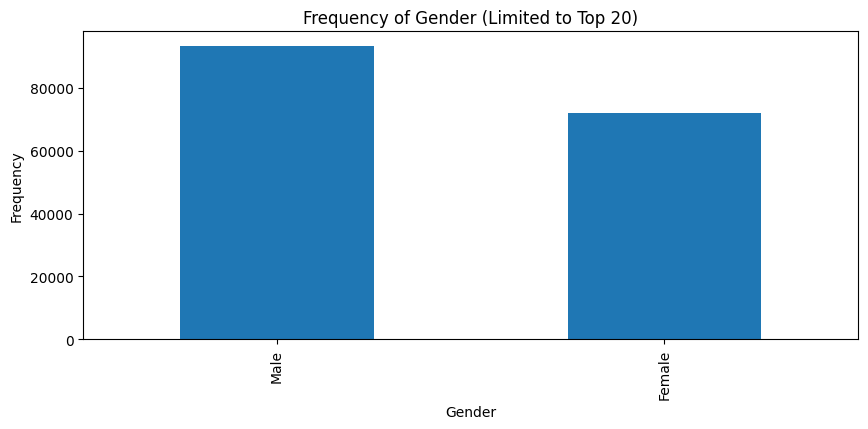

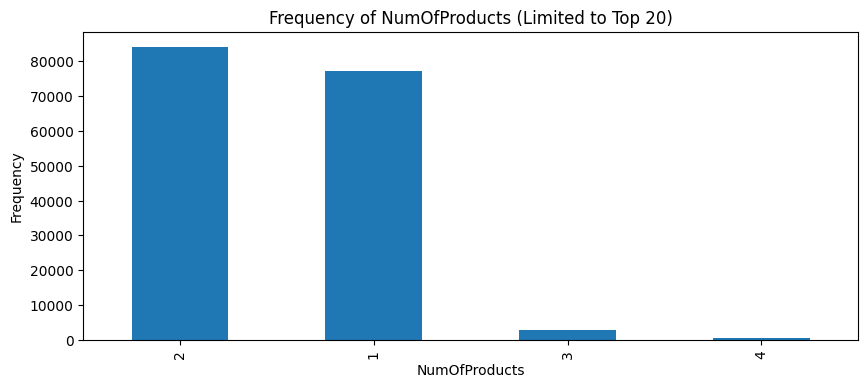

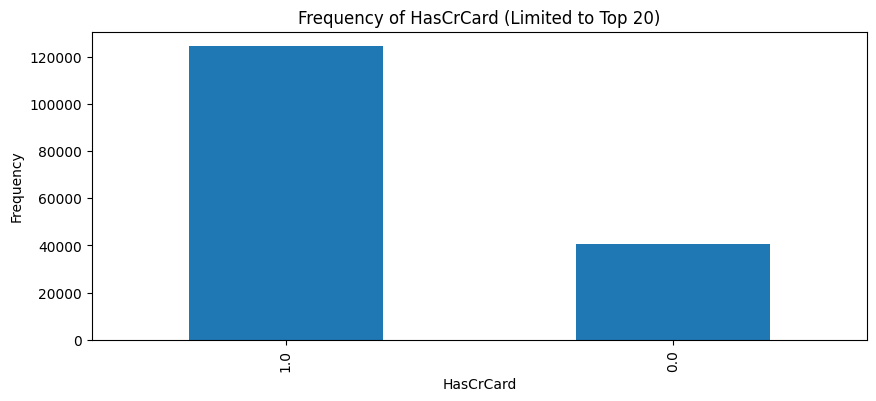

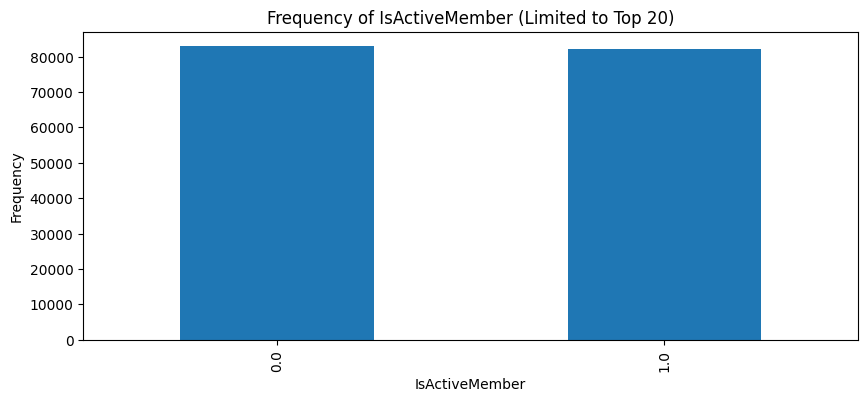

In [ ]:
# Graph distributions of discrete values
categorical_columns = ['Surname', 'Geography', 'Gender', 'NumOfProducts',	'HasCrCard',	'IsActiveMember']

for col in categorical_columns:
    plt.figure(figsize=(10, 4))
    train_df[col].value_counts().head(20).plot.bar()
    plt.title(f'Frequency of {col} (Limited to Top 20)')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.show()

The most significant takeaways across the discrete values here are:


*   A large number of the same surnames. We should remove these since ethnicity could be interpretted by the model, and therefore produce biased results.
*   Over half of the customers are from France! And only three countries are represented here. We could assume this bank is based in France, but it is worth keeping in mind as we look at correlations or saliency later on. It might be best to drop "Geography" as a feature.
*   Above half of members are not considered active.

On to the numerical values.

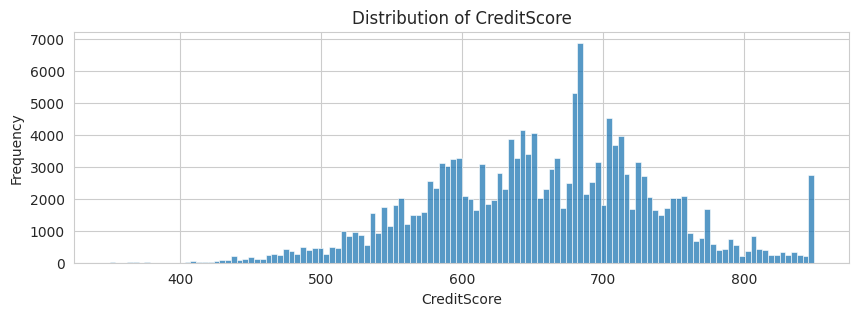

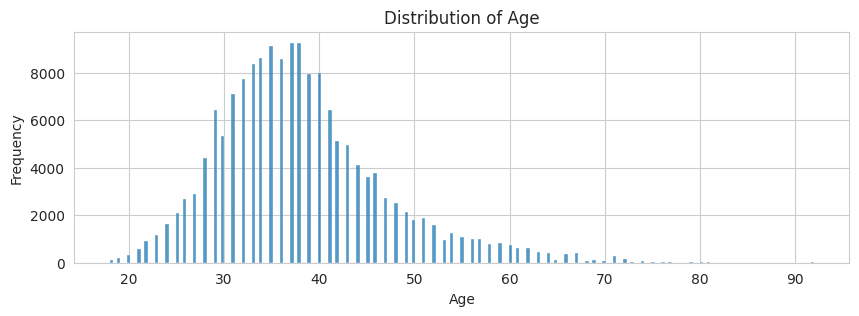

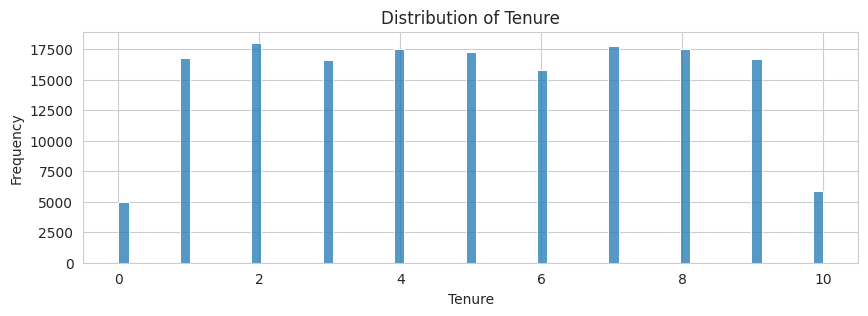

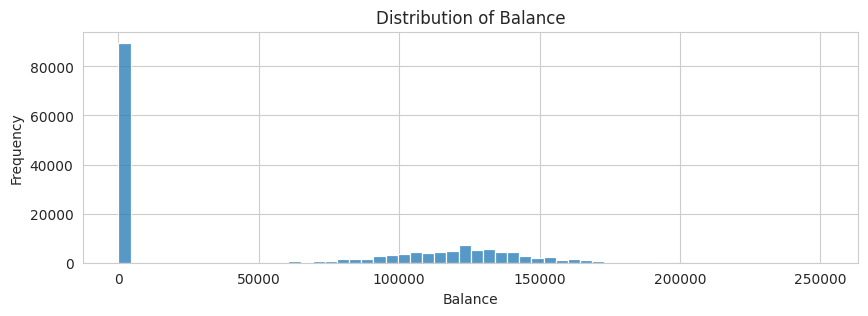

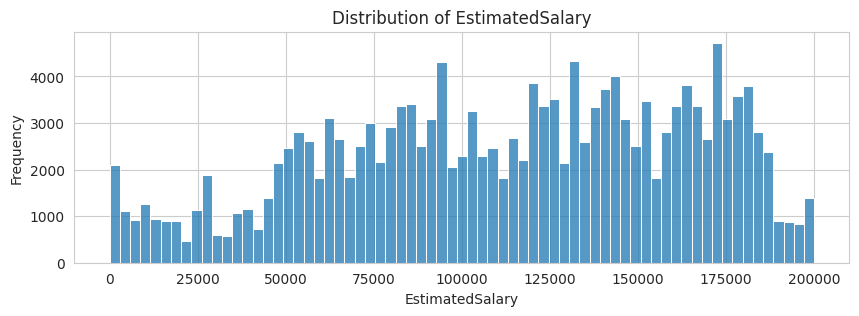

In [ ]:
# Graph distributions of numerical values
numerical_columns = ['CreditScore', 'Age', 'Tenure', 'Balance', 'EstimatedSalary']

for col in numerical_columns:
    plt.figure(figsize=(10, 3))
    sns.set_style("whitegrid")
    sns.histplot(train_df[col])
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.show()

Other than "Balance", these values are pretty fairly consistently distributed along different curves. "Balance" as an outlier at 0, suggesting a large number of customer either do not keep a balance with the bank or they have an opened account that they do not use. The zero balance case may need to be handled separately, but we should verify that the Balance values are actually a numerical value.

In [ ]:
# double check for null values
null_mask = train_df["Balance"].isnull()
print(f"\nNull or NaN values: {len(train_df[null_mask])}")

zeros_mask = train_df["Balance"] == 0
z_count = len(train_df[zeros_mask])
print(f"Zero values: { z_count }")

# verify number of numerical 0s and other numerical values add up to total
gte_zero_mask = train_df["Balance"] > 0
p_count = len(train_df[gte_zero_mask])
print(f"Positive values: { p_count }")

print(f"Total: { p_count + z_count } of {len(train_df.index)} total rows")


Null or NaN values: 0
Zero values: 89648
Positive values: 75386
Total: 165034 of 165034 total rows


Balance values are confirmed as being "true" zero values.

To conclude the exploratory data analysis, look at the correlation values.

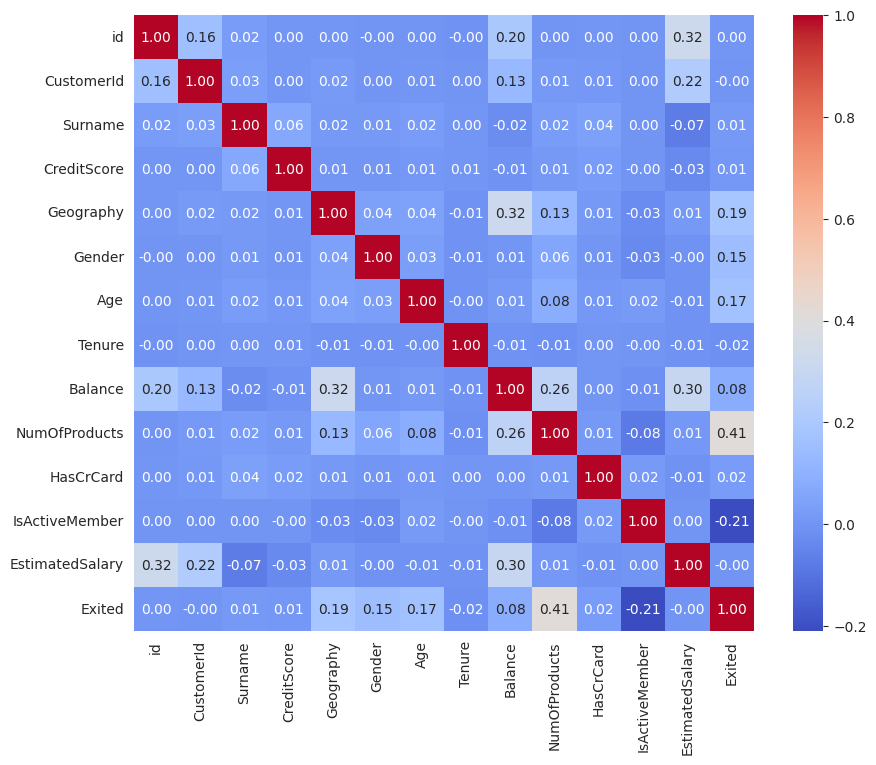

In [ ]:
# Graph correlation of features
converted_df = train_df.apply(lambda x : pd.factorize(x)[0])
correlation_matrix = converted_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.show()

This correlation matrix highlights a few possibilities when preparing are data:


* Surname and salary have a correlation, which further highlights the previous concern around producing a biased model
* "NumOfProducts" has the strongest correlation with exiting, followed by "isActiveMember", "Geography", and "Age"
* "EstimatedSalary" has zero correlationed with exiting, but it does have interaction with other features so it might be worth including
* "CreditScore" has minimal correlation with exiting, which I found somewhat surprising

This gives us our final list of columns to drop, "id", "CustomerId", and "Surname".

### Data Cleaning

First let's remove the columns that do not provide information and might even confuse the model.

In [ ]:
train_df_clean = train_df.drop(['id', 'CustomerId', 'Surname'], axis=1)

Review transformed/cleaned text values.

In [ ]:
train_df_clean.sample(5)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
116236,736,France,Female,39.0,3,0.00,3,0.0,0.0,176943.59,1
107591,650,Germany,Female,35.0,2,145974.79,1,1.0,0.0,90863.74,0
105602,661,France,Female,38.0,9,0.00,2,1.0,0.0,192505.62,0
11140,641,France,Male,32.0,8,0.00,2,1.0,1.0,64859.60,0
135522,490,France,Male,40.0,4,0.00,2,1.0,0.0,171060.01,0


## Data Preparation for Training

The first model type I will be using is somewhat simple multilayer perceptron. To be able to train this model type with the given data, as well as other models for comparison, all data will need to be prepared as numerical.

Additionally, we will want to normalize most values to simplify training and improve speed.

In [ ]:
# Columns that need to be converted to numerical
categorical_columns = ['Geography', 'Gender']

for col in categorical_columns:
    train_df_clean[col] = pd.factorize(train_df_clean[col])[0]

In [ ]:
train_df_clean[categorical_columns].sample(5)

,Geography,Gender
154547,0,1
30788,2,0
111927,0,1
41065,0,1
81221,2,0


Normalization of data points to a 0 - 1 scale.

In [93]:
# normalize all columns except exited
data_norm = train_df_clean
data_norm = (data_norm - data_norm.min()) / (data_norm.max() - data_norm.min())
data_norm.sample(10)

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
118913,0.626,0.5,1.0,0.270270,0.1,0.453544,0.000000,1.0,0.0,0.414345,0.0
38914,0.578,0.5,0.0,0.148649,0.4,0.000000,0.000000,1.0,0.0,0.489906,0.0
42636,0.488,0.0,1.0,0.256757,0.9,0.528955,0.000000,0.0,0.0,0.748011,0.0
77023,0.582,0.5,1.0,0.108108,0.2,0.364881,0.000000,0.0,1.0,0.140742,1.0
151017,0.458,1.0,0.0,0.391892,0.2,0.386180,0.333333,1.0,1.0,0.855520,0.0
63620,0.624,0.0,0.0,0.108108,0.1,0.000000,0.333333,1.0,1.0,0.364627,0.0
98486,0.522,0.5,0.0,0.256757,0.9,0.000000,0.333333,1.0,1.0,0.907777,0.0
68788,0.438,1.0,1.0,0.364865,0.6,0.517721,0.333333,1.0,0.0,0.824857,1.0
2833,0.724,0.0,0.0,0.310811,0.4,0.000000,0.333333,1.0,0.0,0.903138,0.0
134480,0.314,0.0,0.0,0.202703,0.7,0.000000,0.333333,1.0,1.0,0.427105,0.0


Final data preparation is splitting into train and test datasets.

In [ ]:
from sklearn.model_selection import train_test_split

X = data_norm.drop('Exited', axis=1).values
y = data_norm['Exited'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

## Model Training

Configure the first model architecture, a simple multi-layer perceptron.

In [ ]:
# Defining the model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

DIMS = X_train.shape[1]

def build_model(layer_size_factor: 1, middle_layers: 1):
    model = Sequential()
    model.add(Dense(64*layer_size_factor, input_dim=DIMS, activation='relu'))
    for _ in range(middle_layers):
        model.add(Dense(32*layer_size_factor, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))

    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

First round of training. In this case, we're going to test two different batch sizes to gauge an optimal approach for this dataset moving forward.

In [ ]:
model1 = build_model(1)
history1 = model1.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
4126/4126 [==============================] - 16s 3ms/step - loss: 0.3666 - accuracy: 0.8441 - val_loss: 0.3338 - val_accuracy: 0.8588
Epoch 2/10
4126/4126 [==============================] - 13s 3ms/step - loss: 0.3359 - accuracy: 0.8586 - val_loss: 0.3311 - val_accuracy: 0.8607
Epoch 3/10
4126/4126 [==============================] - 13s 3ms/step - loss: 0.3325 - accuracy: 0.8603 - val_loss: 0.3297 - val_accuracy: 0.8606
Epoch 4/10
4126/4126 [==============================] - 14s 3ms/step - loss: 0.3303 - accuracy: 0.8610 - val_loss: 0.3216 - val_accuracy: 0.8650
Epoch 5/10
4126/4126 [==============================] - 14s 3ms/step - loss: 0.3283 - accuracy: 0.8625 - val_loss: 0.3231 - val_accuracy: 0.8646
Epoch 6/10
4126/4126 [==============================] - 13s 3ms/step - loss: 0.3276 - accuracy: 0.8623 - val_loss: 0.3205 - val_accuracy: 0.8660
Epoch 7/10
4126/4126 [==============================] - 14s 3ms/step - loss: 0.3267 - accuracy: 0.8620 - val_loss: 0.3206 - val_ac

In [ ]:
model1b = build_model(1)
history1b = model1b.fit(X_train, y_train, epochs=10, batch_size=256, validation_data=(X_test, y_test))

Epoch 1/10
516/516 [==============================] - 3s 4ms/step - loss: 0.4154 - accuracy: 0.8218 - val_loss: 0.3452 - val_accuracy: 0.8521
Epoch 2/10
516/516 [==============================] - 2s 3ms/step - loss: 0.3411 - accuracy: 0.8561 - val_loss: 0.3345 - val_accuracy: 0.8588
Epoch 3/10
516/516 [==============================] - 2s 3ms/step - loss: 0.3348 - accuracy: 0.8593 - val_loss: 0.3284 - val_accuracy: 0.8625
Epoch 4/10
516/516 [==============================] - 2s 3ms/step - loss: 0.3328 - accuracy: 0.8598 - val_loss: 0.3299 - val_accuracy: 0.8615
Epoch 5/10
516/516 [==============================] - 2s 3ms/step - loss: 0.3319 - accuracy: 0.8609 - val_loss: 0.3263 - val_accuracy: 0.8626
Epoch 6/10
516/516 [==============================] - 2s 3ms/step - loss: 0.3308 - accuracy: 0.8613 - val_loss: 0.3247 - val_accuracy: 0.8642
Epoch 7/10
516/516 [==============================] - 2s 3ms/step - loss: 0.3305 - accuracy: 0.8613 - val_loss: 0.3254 - val_accuracy: 0.8643
Epoch 

In [ ]:
# Graph loss rates for different model histories side-by-side
# My go-to function that continues to evolve - feel free to use!
def graph_loss(labels, *histories):
    num_histories = len(histories)
    num_columns = min(num_histories, 3)
    num_rows = (num_histories + 2) // 3
    # set layout
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    if num_histories == 1:
        axs = [axs]

    # make iterable
    axs = axs.flatten()
    i = 0
    for ax, history in zip(axs, histories):
        label = labels[i]
        ax.plot(history.history['loss'])
        ax.plot(history.history['val_loss'])
        ax.set_title(f'{label} Loss')
        ax.set_ylabel('Loss')
        ax.set_xlabel('Epoch')
        ax.legend(['Train', 'Validation'], loc='upper right')
        i += 1

    # Hide unused subplots
    for ax in axs[num_histories:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

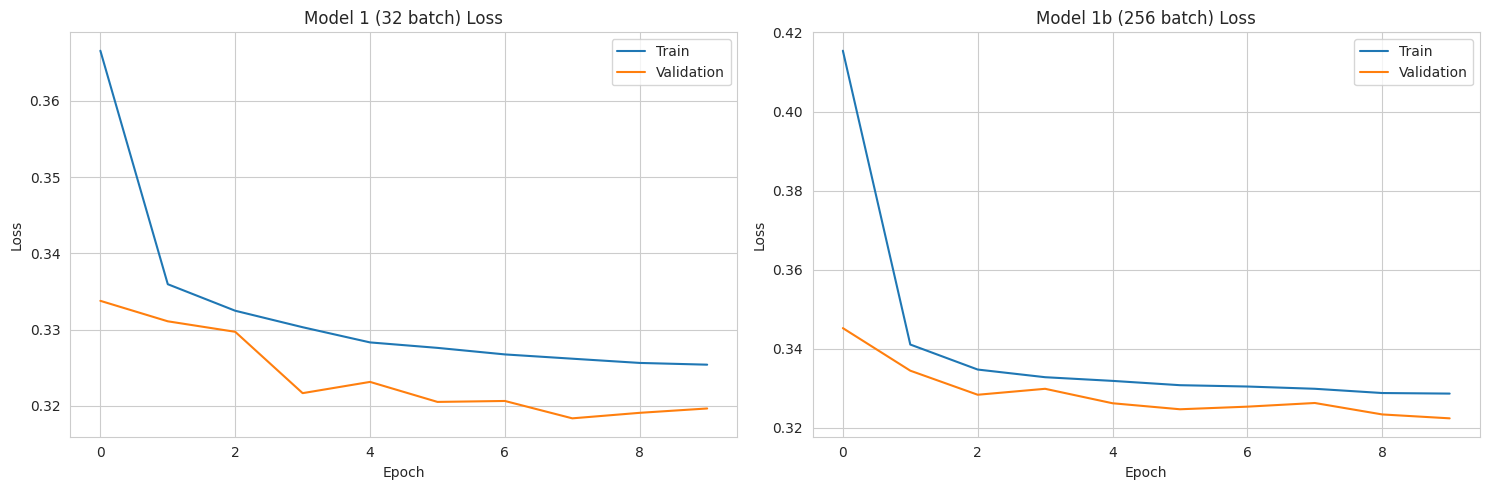

In [ ]:
graph_loss(['Model 1 (32 batch)', 'Model 1b (256 batch)'], history1, history1b)

Regarding batch size, it seems a smaller value allows for quicker learning over the same number of epochs. I'm going to split the difference slightly moving forward since it also seems a larger batch size minimizes validation loss relative to training loss.

Now let's compare larger networks, both wider and deeper.

In [ ]:
width_factors = [1, 2, 4]
depth_factors = [1, 2, 4]
larger_mlps = []
larger_mlps_histories = []
larger_mlps_labels = []

for width_factor in width_factors:
    for depth_factor in depth_factors:
        model = build_model(width_factor, depth_factor)
        print(f'Training with {width_factor}x width and {depth_factor+1} depth')
        larger_mlps.append(model)
        larger_mlps_histories.append(model.fit(X_train, y_train, epochs=10, batch_size=64, validation_data=(X_test, y_test)))
        larger_mlps_labels.append(f'MLP {width_factor}x width, {depth_factor+1} depth')

Training with 1x width and 2 depth
Epoch 1/10
2063/2063 [==============================] - 8s 3ms/step - loss: 0.3812 - accuracy: 0.8368 - val_loss: 0.3375 - val_accuracy: 0.8592
Epoch 2/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3374 - accuracy: 0.8580 - val_loss: 0.3364 - val_accuracy: 0.8610
Epoch 3/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3332 - accuracy: 0.8602 - val_loss: 0.3257 - val_accuracy: 0.8649
Epoch 4/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3315 - accuracy: 0.8611 - val_loss: 0.3317 - val_accuracy: 0.8611
Epoch 5/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3294 - accuracy: 0.8614 - val_loss: 0.3239 - val_accuracy: 0.8628
Epoch 6/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3277 - accuracy: 0.8624 - val_loss: 0.3200 - val_accuracy: 0.8668
Epoch 7/10
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3270 - accuracy: 0.8624

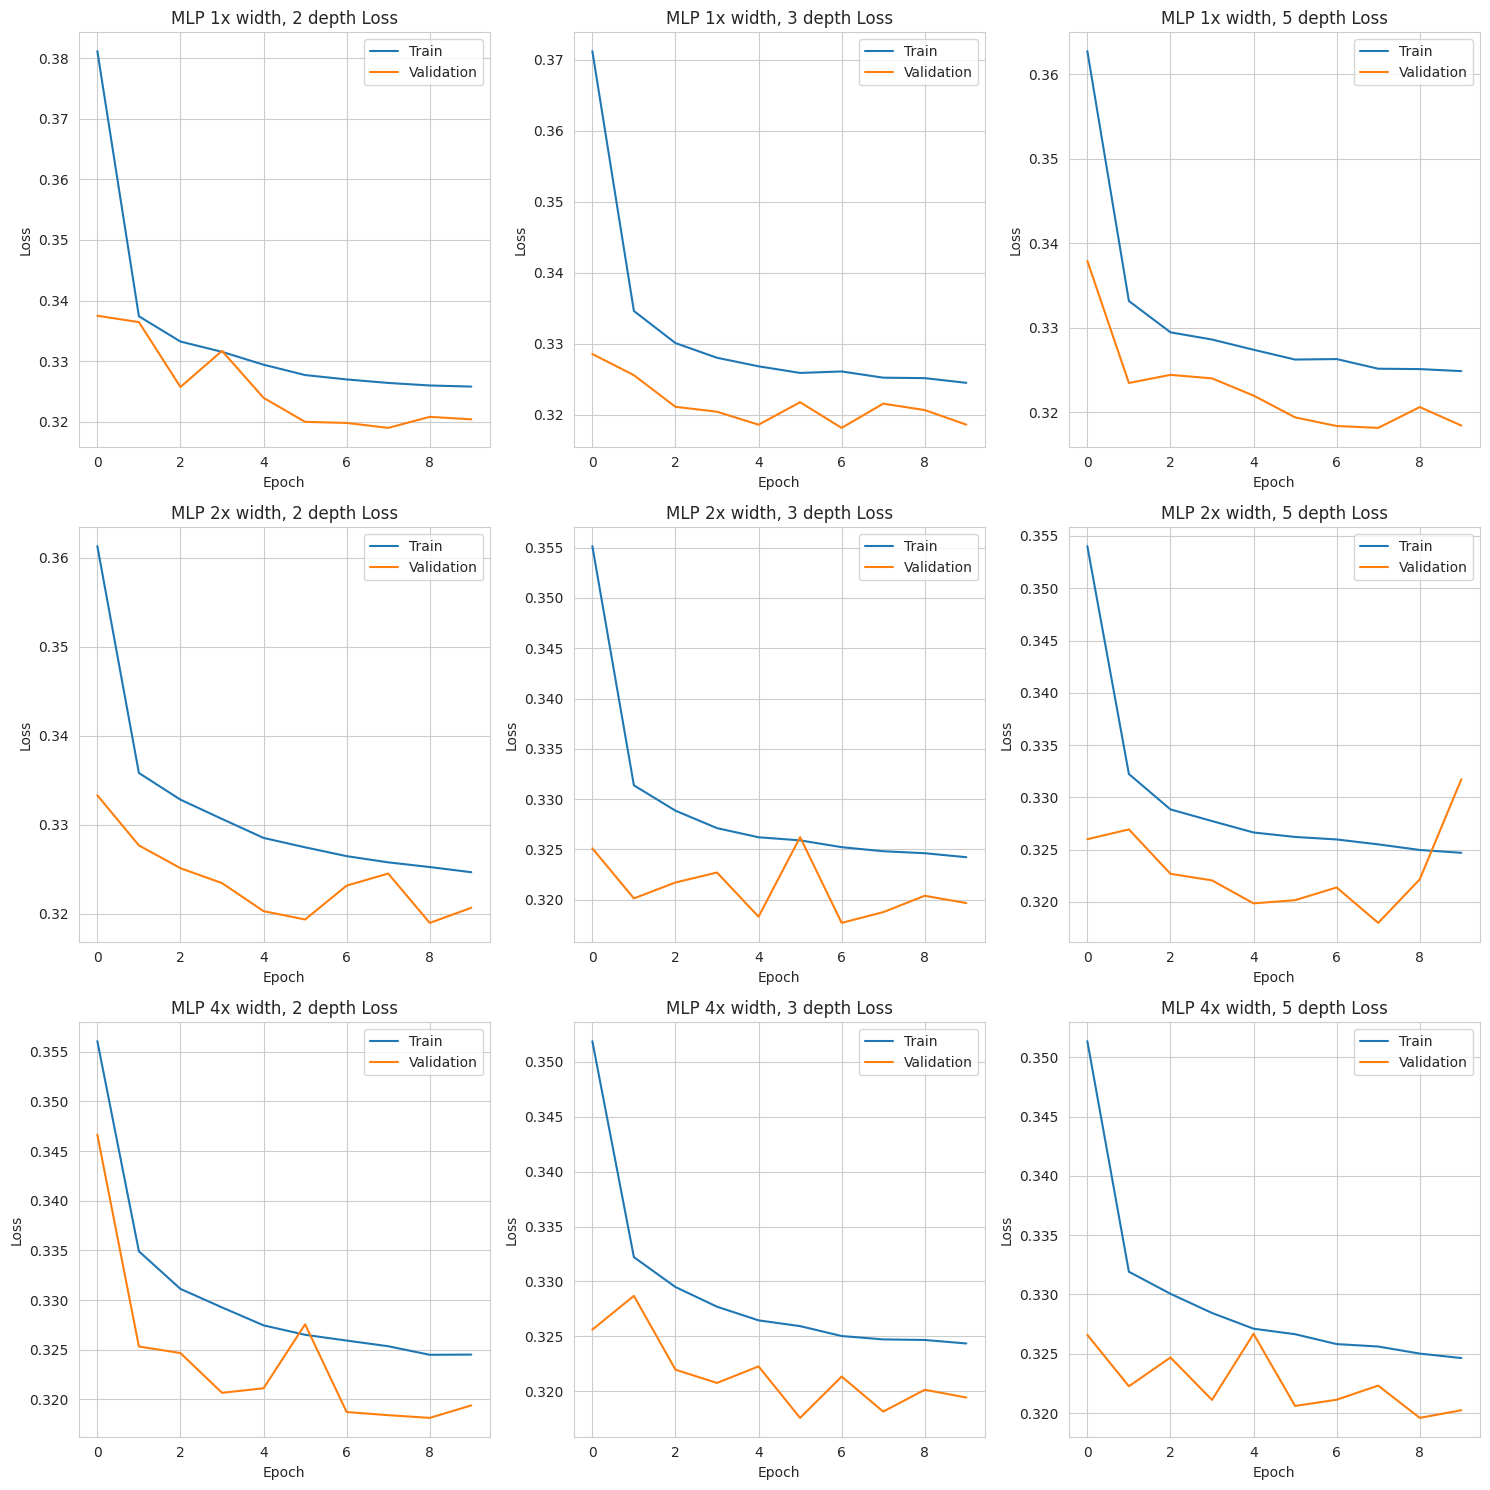

In [ ]:
graph_loss(larger_mlps_labels, *larger_mlps_histories)

From these results it appears that wider networks perform a bit better, and depth did not have an impact. Additionally, in all of these cases validation loss stayed lower than the training loss, suggesting underfitting. This might be primarily due to insufficient training epochs. Next I'll increase the epochs for the two most promising configurations.

In [ ]:
modelBW = build_model(4, 1)
modelBD = build_model(2, 2)

historyBW = modelBW.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3565 - accuracy: 0.8484 - val_loss: 0.3300 - val_accuracy: 0.8599
Epoch 2/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3334 - accuracy: 0.8599 - val_loss: 0.3250 - val_accuracy: 0.8642
Epoch 3/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3299 - accuracy: 0.8619 - val_loss: 0.3233 - val_accuracy: 0.8658
Epoch 4/30
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3277 - accuracy: 0.8623 - val_loss: 0.3206 - val_accuracy: 0.8655
Epoch 5/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3268 - accuracy: 0.8630 - val_loss: 0.3205 - val_accuracy: 0.8659
Epoch 6/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3261 - accuracy: 0.8627 - val_loss: 0.3206 - val_accuracy: 0.8666
Epoch 7/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3254 - accuracy: 0.8627 - val_loss: 0.3193 - val_accuracy:

In [ ]:
historyBD = modelBD.fit(X_train, y_train, epochs=30, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/30
2063/2063 [==============================] - 8s 3ms/step - loss: 0.3562 - accuracy: 0.8489 - val_loss: 0.3269 - val_accuracy: 0.8631
Epoch 2/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3322 - accuracy: 0.8595 - val_loss: 0.3246 - val_accuracy: 0.8645
Epoch 3/30
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3293 - accuracy: 0.8614 - val_loss: 0.3199 - val_accuracy: 0.8671
Epoch 4/30
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3273 - accuracy: 0.8629 - val_loss: 0.3225 - val_accuracy: 0.8656
Epoch 5/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3264 - accuracy: 0.8628 - val_loss: 0.3239 - val_accuracy: 0.8644
Epoch 6/30
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3257 - accuracy: 0.8630 - val_loss: 0.3195 - val_accuracy: 0.8673
Epoch 7/30
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3255 - accuracy: 0.8627 - val_loss: 0.3203 - val_accuracy:

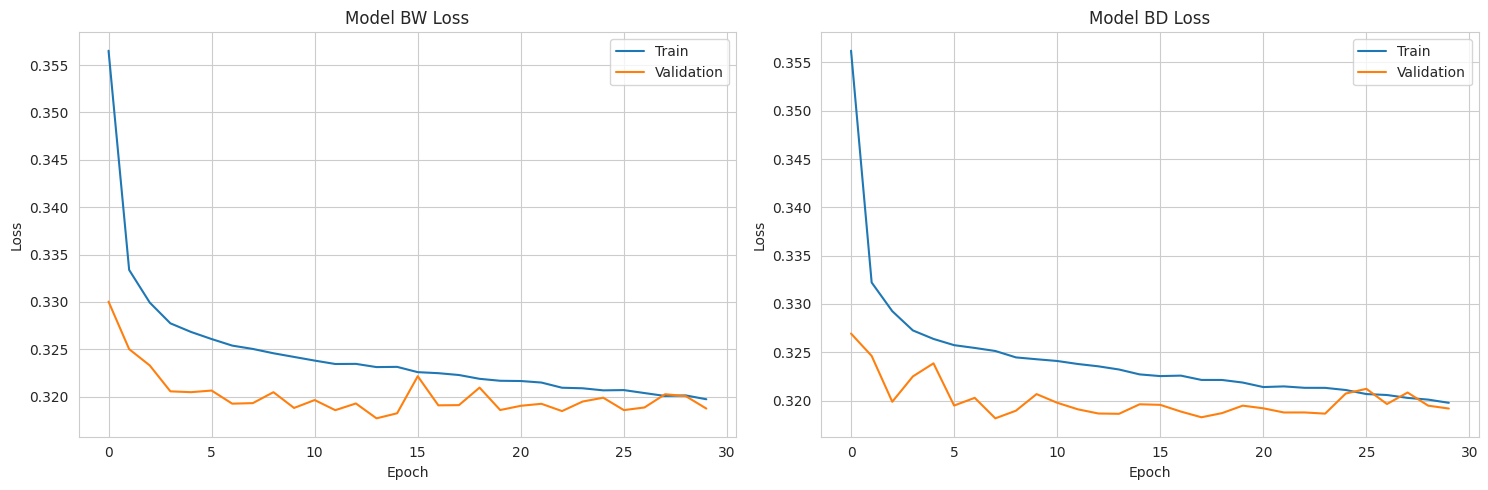

In [ ]:
graph_loss(['Model BW', 'Model BD'], historyBW, historyBD)

In [ ]:
# Now that its reaching convergence, plot accuracy for more insight
import matplotlib.pyplot as plt
from sklearn.metrics import auc

def graph_accuracy(labels, *histories):
    num_histories = len(histories)
    num_columns = min(num_histories, 3)
    num_rows = (num_histories + 2) // 3
    fig, axs = plt.subplots(num_rows, num_columns, figsize=(15, 5 * num_rows))
    if num_histories == 1:
        axs = [axs]

    # make iterable
    axs = axs.flatten()
    i = 0
    for ax, history in zip(axs, histories):
        label = labels[i]
        train_accuracy = history.history['accuracy']
        val_accuracy = history.history['val_accuracy']
        x_epochs = range(1, len(train_accuracy) + 1)
        train_auc = auc(x_epochs, train_accuracy)
        val_auc = auc(x_epochs, val_accuracy)
        ax.plot(x_epochs, train_accuracy, label=f'Train AUC: {train_auc:.2f}')
        ax.plot(x_epochs, val_accuracy, label=f'Validation AUC: {val_auc:.2f}')

        ax.set_title(f'{label} Accuracy')
        ax.set_ylabel('Accuracy')
        ax.set_xlabel('Epoch')
        ax.legend(loc='lower right')
        i += 1
    for ax in axs[num_histories:]:
        ax.axis('off')
    plt.tight_layout()
    plt.show()

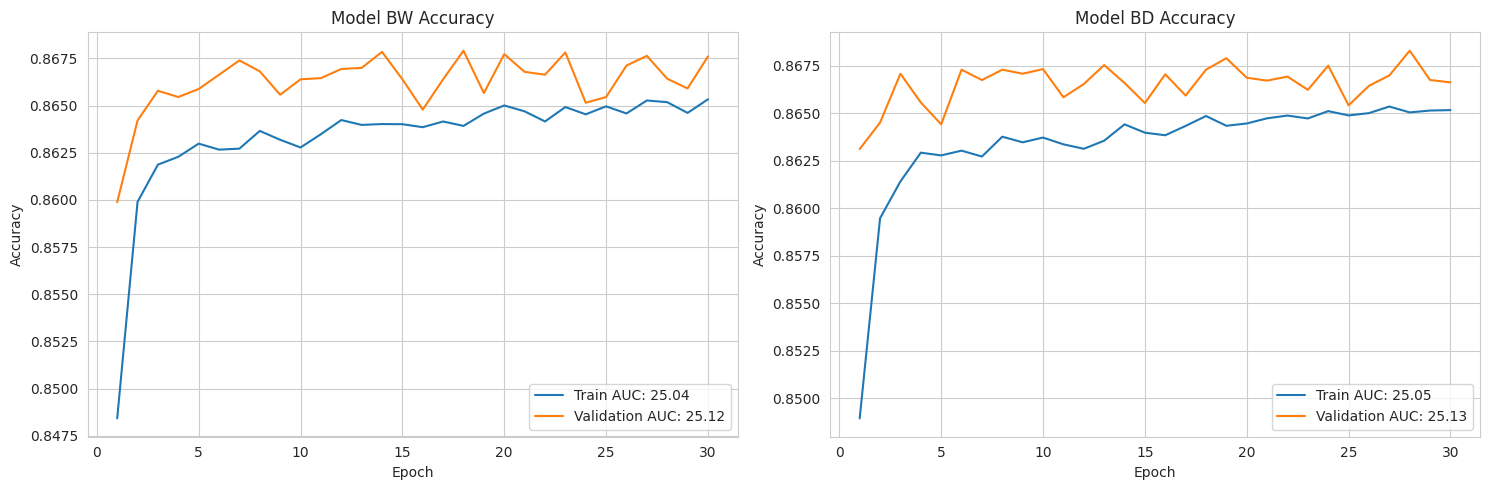

In [ ]:
graph_accuracy(['Model BW', 'Model BD'], historyBW, historyBD)

In the case of this dataset guessing zero, or not "exiting", will achieve close to 80% accuracy due to the label distribution so these results aren't especially promising. Time to try introducing new regularization parameters to avoid overfitting on the negative samples.

In [ ]:
from keras.layers import Dropout
from keras.regularizers import l1, l2

def build_model_reg(layer_size_factor=1, middle_layers=1, l1_reg=0.0, l2_reg=0.0, dropout_rate=0.0):
    model = Sequential()
    model.add(Dense(64 * layer_size_factor,
                    input_dim=DIMS,
                    activation='relu',
                    kernel_regularizer=l1(l1_reg) if l1_reg > 0 else None,
                    activity_regularizer=l2(l2_reg) if l2_reg > 0 else None))

    for _ in range(middle_layers):
        model.add(Dense(32 * layer_size_factor,
                        activation='relu',
                        kernel_regularizer=l1(l1_reg) if l1_reg > 0 else None,
                        activity_regularizer=l2(l2_reg) if l2_reg > 0 else None))
        if dropout_rate > 0:
            model.add(Dropout(dropout_rate))

    model.add(Dense(1, activation='sigmoid'))

    return model

In [ ]:
# Compare model results with and without l1 regularization, l2 regularization, and dropout layers
# Use width factor 2, layer depth 2 for all
l1_reg_factors = [0.0, 0.01, 0.1]
l2_reg_factors = [0.0, 0.01, 0.1]
dropout_rate_factors = [0.0, 0.1, 0.2]

mlps_with_reg = []
histories_with_reg = []
labels_with_reg = []


In [71]:
for l1_reg_factor in l1_reg_factors:
    for l2_reg_factor in l2_reg_factors:
        for dropout_rate_factor in dropout_rate_factors:
            model = build_model_reg(2, 2, l1_reg_factor, l2_reg_factor, dropout_rate_factor)
            print(f'Training with l1={l1_reg_factor}, l2={l2_reg_factor}, dropout={dropout_rate_factor}')
            model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
            history = model.fit(X_train, y_train, epochs=20, batch_size=64, validation_data=(X_test, y_test))
            mlps_with_reg.append(model)
            histories_with_reg.append(history)
            labels_with_reg.append(f'MLP (l1 {l1_reg_factor}, l2 {l2_reg_factor}, dropout {dropout_rate_factor})')




Training with l1=0.0, l2=0.0, dropout=0.0
Epoch 1/20
2063/2063 [==============================] - 9s 4ms/step - loss: 0.3546 - accuracy: 0.8497 - val_loss: 0.3302 - val_accuracy: 0.8602
Epoch 2/20
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3321 - accuracy: 0.8608 - val_loss: 0.3259 - val_accuracy: 0.8660
Epoch 3/20
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3287 - accuracy: 0.8618 - val_loss: 0.3217 - val_accuracy: 0.8654
Epoch 4/20
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3275 - accuracy: 0.8624 - val_loss: 0.3190 - val_accuracy: 0.8671
Epoch 5/20
2063/2063 [==============================] - 7s 3ms/step - loss: 0.3265 - accuracy: 0.8621 - val_loss: 0.3251 - val_accuracy: 0.8624
Epoch 6/20
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3259 - accuracy: 0.8627 - val_loss: 0.3185 - val_accuracy: 0.8675
Epoch 7/20
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3255 - accuracy:

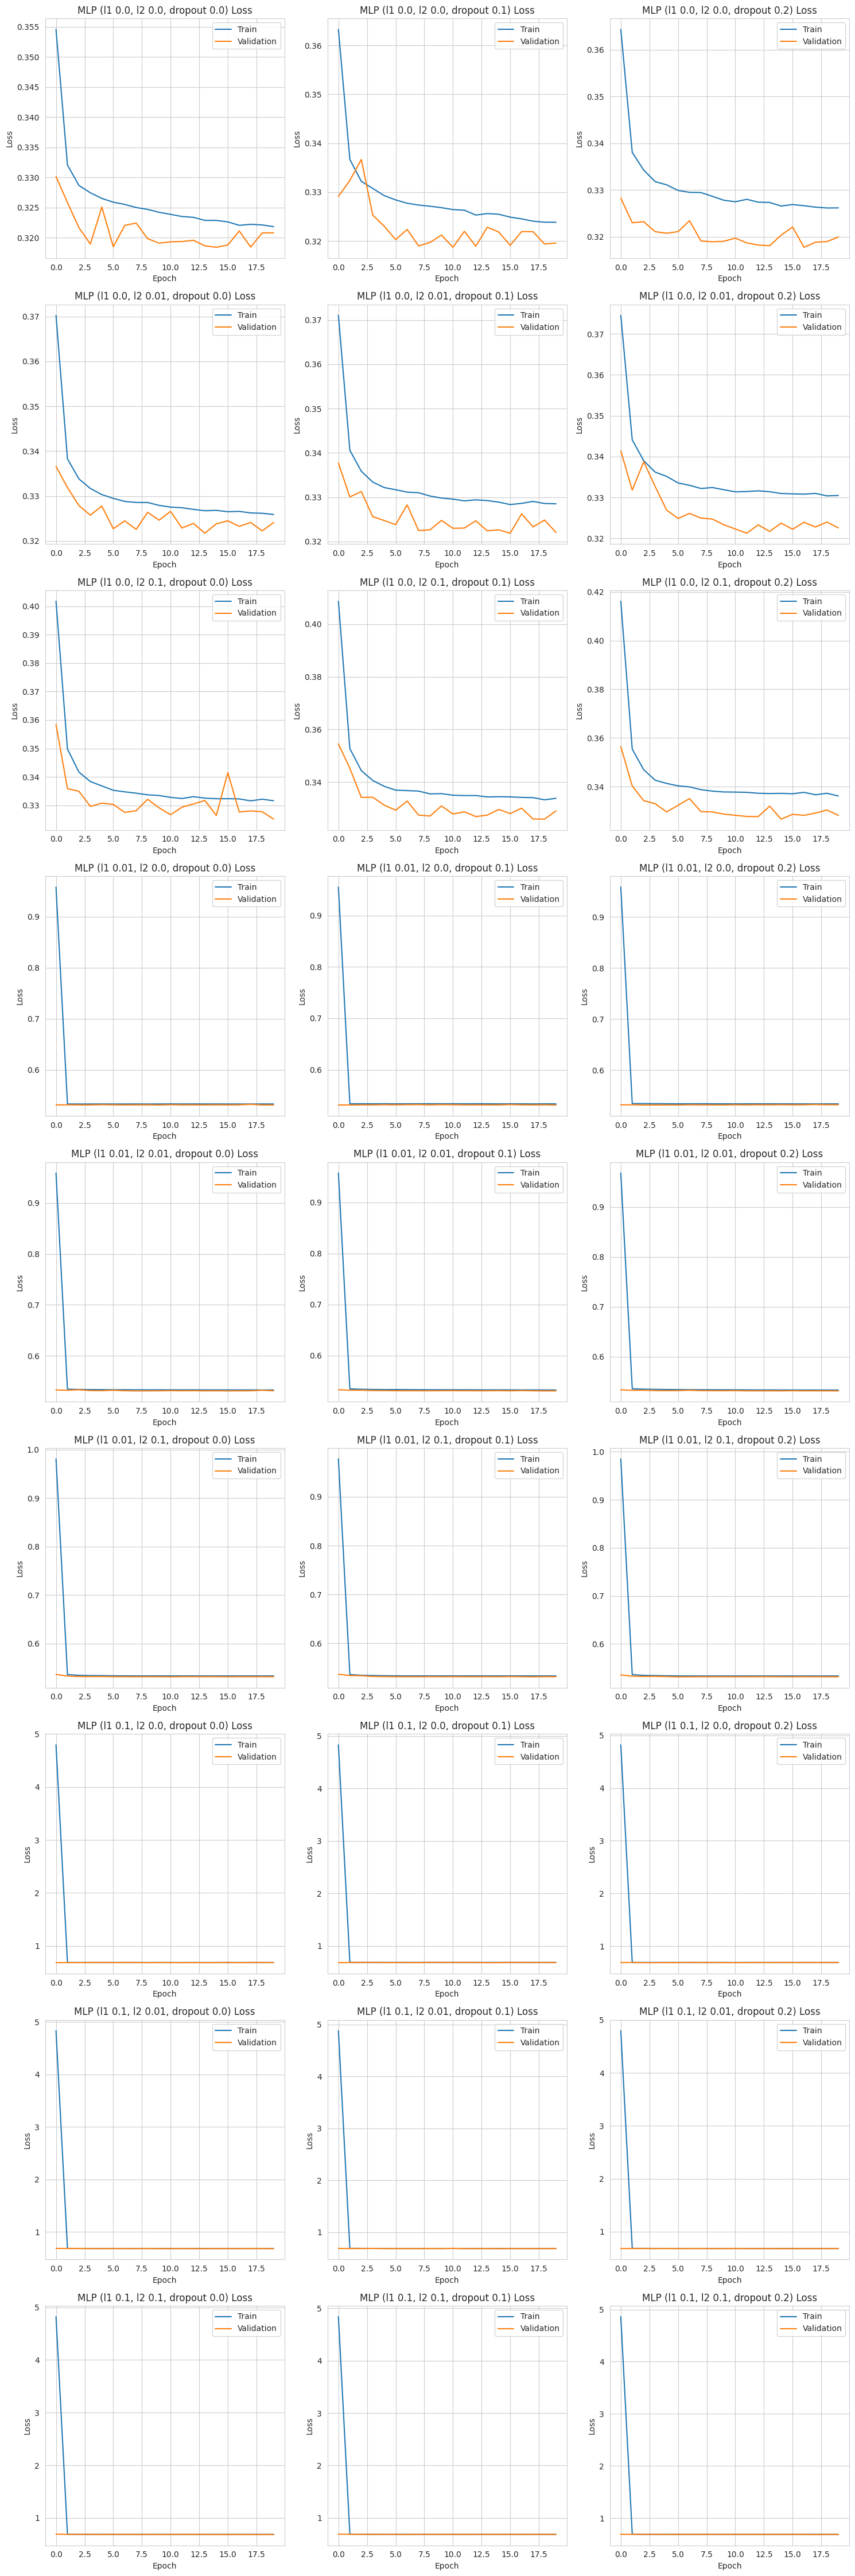

In [72]:
# Compare regularized models
graph_loss(labels_with_reg, *histories_with_reg)

The addition of L1 and L2 regularatization did not help in this case, however a dropout layer did provide more consistency in generalization.

#### Comparing Dropout Layer Accuracies

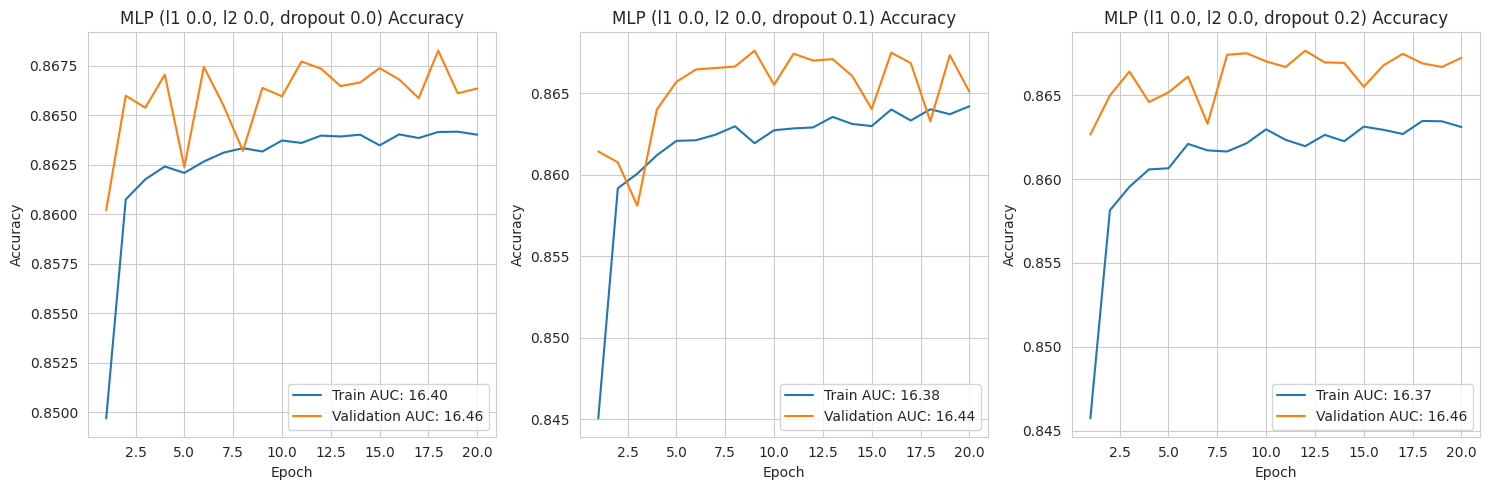

In [74]:
graph_accuracy(labels_with_reg[0:3], *histories_with_reg[0:3])

In this case, I have selected the MLP with 0.2 dropout as the stronger model. Since the AUC values are essentially the same, final validation accuracy is a touch higher for a 20% dropout rate, and overall validation training was smoother, it should train more consistently.

Let's test a longer training to reach convergence.

In [82]:
model_reg_02_long = build_model_reg(2, 2, 0, 0, 0.2)
model_reg_02_long.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
model_reg_02_history = model_reg_02_long.fit(X_train, y_train, epochs=60, batch_size=64, validation_data=(X_test, y_test))

Epoch 1/60
2063/2063 [==============================] - 9s 4ms/step - loss: 0.3664 - accuracy: 0.8454 - val_loss: 0.3295 - val_accuracy: 0.8619
Epoch 2/60
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3380 - accuracy: 0.8580 - val_loss: 0.3271 - val_accuracy: 0.8625
Epoch 3/60
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3331 - accuracy: 0.8606 - val_loss: 0.3233 - val_accuracy: 0.8652
Epoch 4/60
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3316 - accuracy: 0.8615 - val_loss: 0.3229 - val_accuracy: 0.8662
Epoch 5/60
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3304 - accuracy: 0.8615 - val_loss: 0.3189 - val_accuracy: 0.8677
Epoch 6/60
2063/2063 [==============================] - 8s 4ms/step - loss: 0.3301 - accuracy: 0.8620 - val_loss: 0.3248 - val_accuracy: 0.8641
Epoch 7/60
2063/2063 [==============================] - 7s 4ms/step - loss: 0.3292 - accuracy: 0.8614 - val_loss: 0.3194 - val_accuracy:

Comparing the previous strong "wide" neural network to a slightly less wide network with a dropout layer.

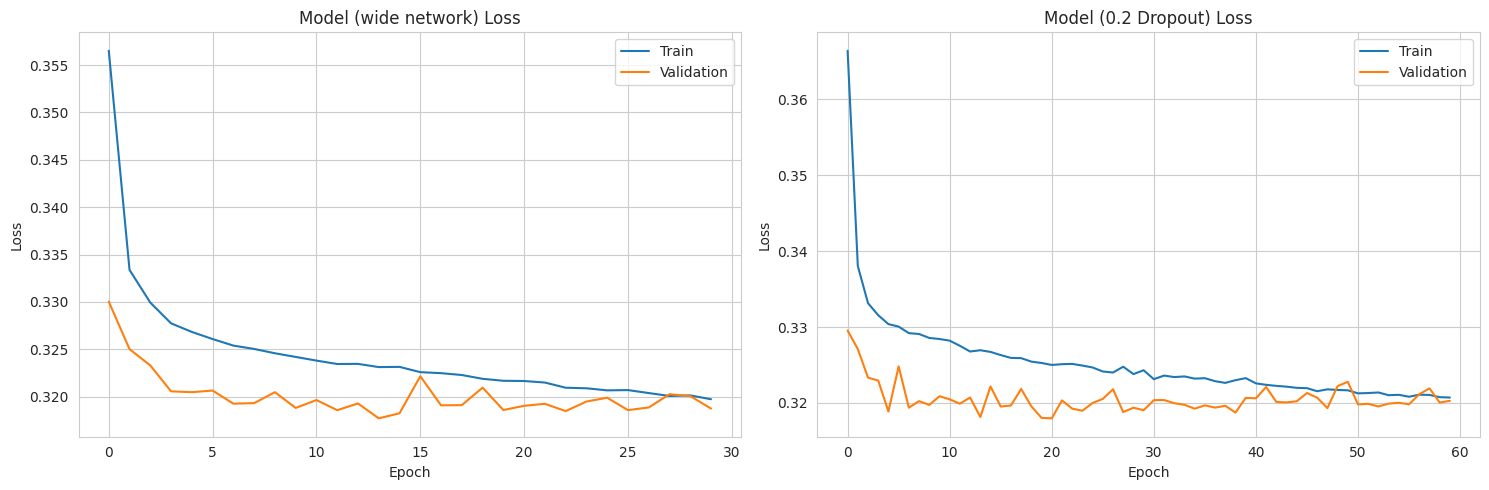

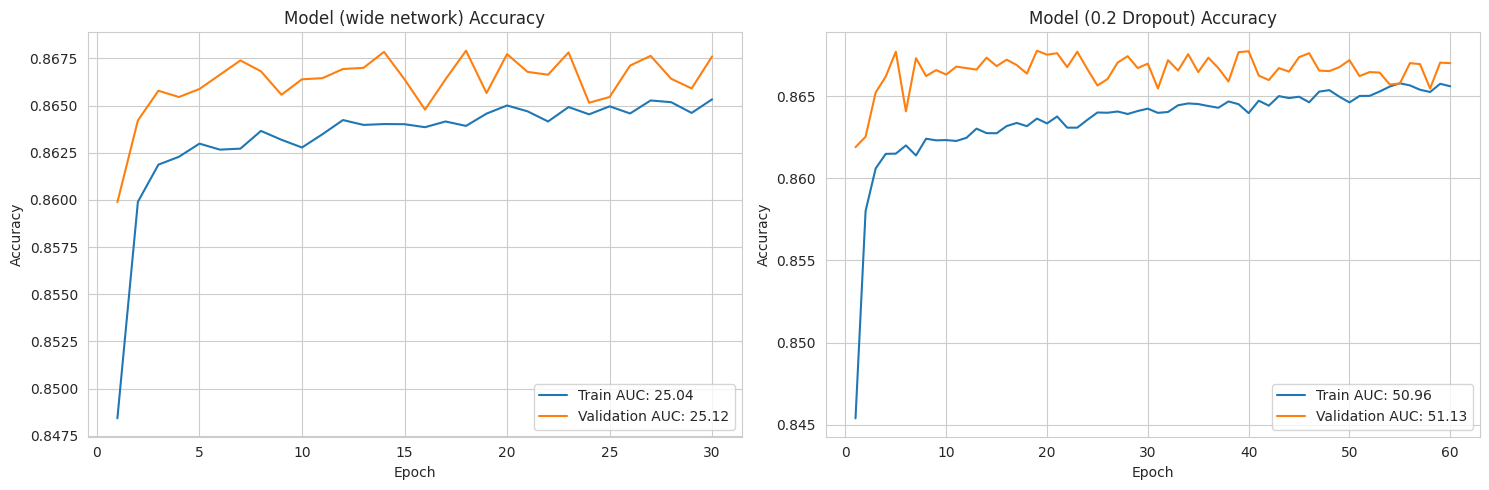

In [94]:
graph_loss(['Model (wide network)', 'Model (0.2 Dropout)'], historyBW, model_reg_02_history)
graph_accuracy(['Model (wide network)', 'Model (0.2 Dropout)'], historyBW, model_reg_02_history)

As shown in the loss and accuracy graphs, continued training of the moderately wide MLP with a 20% rate dropout layer showed continued improvements. The final accuracy values were slightly higher, largely due to the fact that it could be trained longer without converging.

## Conclusion & Analysis

This neural network focused machine learning project aimed to predict customer churn for a synthetic bank dataset retrieved from Kaggle.  The primary goal was to compare the performance of various machine learning architectures on the customer churn prediction task. The dataset comprised 165,034 samples, with a skew towards negative samples (customers not exiting), which was taken into consideration when evaluating model results.

The first model trained was a simple multi-layer perceptron (MLP) model. From there, by testing different configurations of MLPs, varying in width and depth, I concluded that wider networks performed slightly better, with no significant gain from increased depth. Further, I found that a moderately wide MLP with a 20% dropout layer offered better generalization and consistent improvements in validation accuracy. This was particularly important as a model guessing 'not exiting' would already achieve approximately 80% accuracy due to label distribution.

### Future Improvements

The final results favored a moderately wide MLP with dropout regularization since it enabled longer training without overfitting, especially on the negative samples. In future work, there might be more sophisticated model architectures like convolutional neural networks (CNNs) that would be able abstract feature combinations better. There may also be techniques to address the feature and label imbalance. In terms of real world application, developing a model such as this for use at an actual organization would likely see the largest benefits from additional data gathering and feature engineering.

### Appendix A: Resources and References

Bank Churn Dataset
> Walter Reade, Ashley Chow. (2024). Binary Classification with a Bank Churn Dataset . Kaggle. https://kaggle.com/competitions/playground-series-s4e1

Classification with Modern MLP
> Khalid Salama. (2024). Image classification with modern MLP models. https://keras.io/examples/vision/mlp_image_classification/

Dropout Regulrization Technique
> Kurtis Pykes. (2022). Dropout Regularization With Tensorflow Keras https://www.comet.com/site/blog/dropout-regularization-with-tensorflow-keras/

L1 and L2 Regularization Techniques
> Jason Brownlee. (2020). How to Use Weight Decay to Reduce Overfitting of Neural Network in Keras. https://machinelearningmastery.com/how-to-reduce-overfitting-in-deep-learning-with-weight-regularization/

### Appendix B: Kaggle Competition Submission

In [89]:
# Predict and output for test data
test_df_clean = test_df.drop(['id', 'CustomerId', 'Surname'], axis=1)

for col in categorical_columns:
    test_df_clean[col] = pd.factorize(test_df_clean[col])[0]
test_norm = test_df_clean
test_norm = (test_norm - test_norm.min()) / (test_norm.max() - test_norm.min())
x_test_values = test_norm.values
test_pred = model_reg_02_long.predict(x_test_values)
test_targets = (test_pred > 0.5).astype("int32")

3439/3439 [==============================] - 5s 1ms/step


In [90]:
# Reduce columns to just ids
submission_df = test_df.loc[:, test_df.columns.intersection(['id'])]
submission_df['Exited'] = test_targets
submission_df.to_csv('submission.csv', index=False)

In [91]:
# Kaggle submission
!kaggle competitions submit -c playground-series-s4e1 -f submission.csv -m "DTSA-5511, v1"

100% 967k/967k [00:02<00:00, 396kB/s]
Successfully submitted to Binary Classification with a Bank Churn Dataset 